In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import pandas as pd
import numpy as np
import re
import pickle
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, SMOTENC
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from itertools import combinations
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import mannwhitneyu, shapiro, probplot
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
!pip install catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

     |████████████████████████████████| 76.3 MB 1.1 MB/s 


In [ ]:
train_path = '/content/drive/My Drive/data/churn_median/train.csv'
test_path = '/content/drive/My Drive/data/churn_median/test.csv'
TARGET_NAME = 'Is_Lead'
np.random.seed(1)

In [ ]:
train_df = pd.read_csv(train_path)
# test_df = pd.read_csv(test_path)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [ ]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [ ]:
train_df.Is_Lead.value_counts(normalize=True)

0    0.762792
1    0.237208
Name: Is_Lead, dtype: float64

In [ ]:
train_df.describe()
# vinatage distribution?
# Balance distribution?

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [ ]:
train_df.describe(include=[np.object])  # get statistics from categorical features

,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
count,245725,245725,245725,245725,245725,216400,245725
unique,245725,2,35,4,4,2,2
top,YRQPDZA2,Male,RG268,Self_Employed,X1,No,No
freq,1,134197,35934,100886,103718,144357,150290


In [ ]:
for idx, col in enumerate(train_df.columns[:-1]):
    print(train_df[col].value_counts())
    print('='*40)

XUWSGHSN    1
TAJQXDMO    1
B5FWNSME    1
3JRLDVDJ    1
RWEUSJPG    1
           ..
JRQVPSCV    1
46IEJ4XS    1
FFHQ7O3X    1
H89AEEV9    1
RX8ES5QJ    1
Name: ID, Length: 245725, dtype: int64
Male      134197
Female    111528
Name: Gender, dtype: int64
28    14533
29    13284
27    13005
30    11066
26     9039
      ...  
82      749
83      694
84      624
85      604
23        1
Name: Age, Length: 63, dtype: int64
RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64
Self_Employed    1008

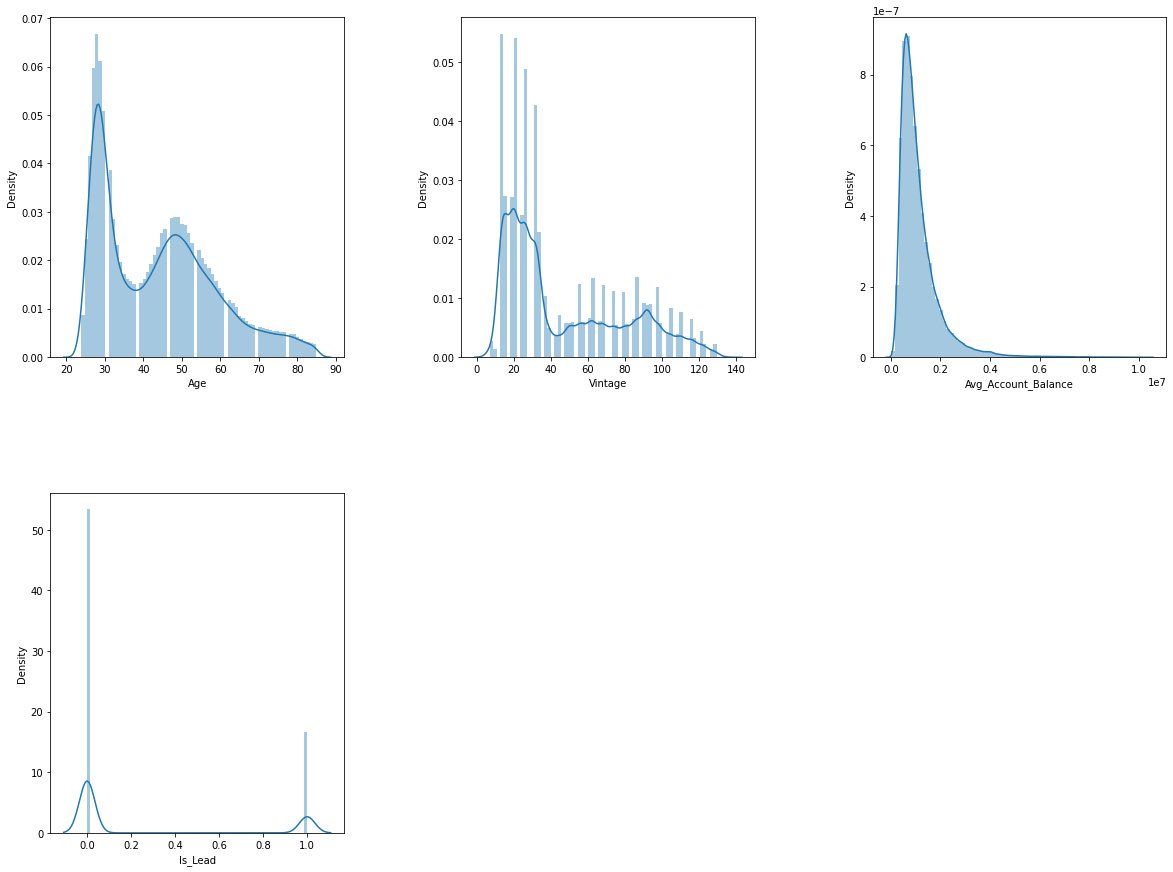

In [ ]:
plt.figure(figsize=(20, 15))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    sns.distplot(train_df[col], bins=70)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

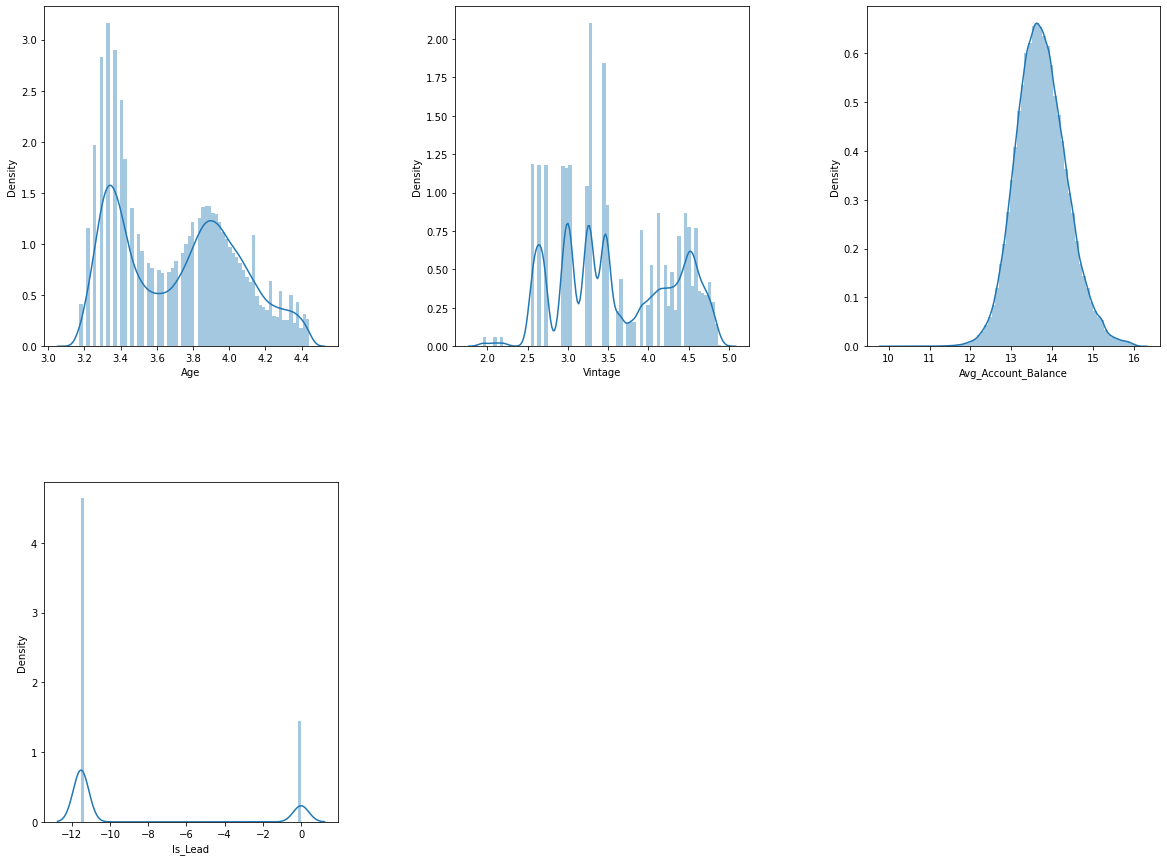

In [ ]:
plt.figure(figsize=(20, 15))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    sns.distplot(np.log(train_df[col] + 1e-5), bins=70)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

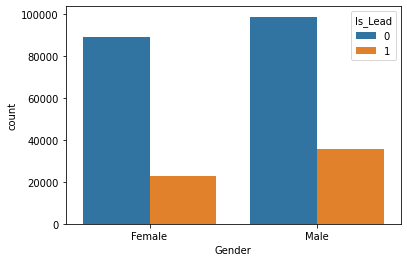

In [ ]:
"""
plt.figure(figsize=(20, 15))
for idx, col in enumerate(train_df.select_dtypes(['object']).columns, 1):
    plt.subplot(2, 3, idx)
    sns.countplot(x=col, hue=TARGET_NAME, data=train_df)  # barplot
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
"""
sns.countplot(x='Gender', hue=TARGET_NAME, data=train_df)
plt.show()
# Gender does not play important role

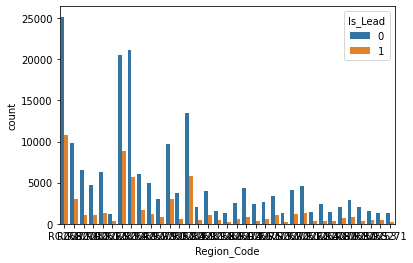

In [ ]:
sns.countplot(x='Region_Code', hue=TARGET_NAME, data=train_df)
plt.show()

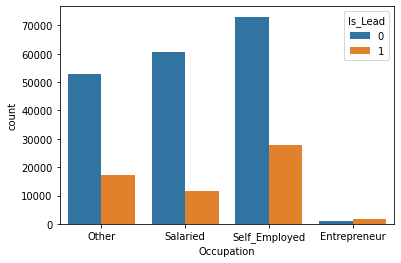

In [ ]:
sns.countplot(x='Occupation', hue=TARGET_NAME, data=train_df)
plt.show()
# Salaried and Self_employed have similar division? union?

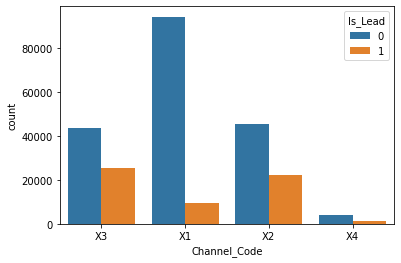

In [ ]:
sns.countplot(x='Channel_Code', hue=TARGET_NAME, data=train_df)
plt.show()
# X3, X2, X4 union?

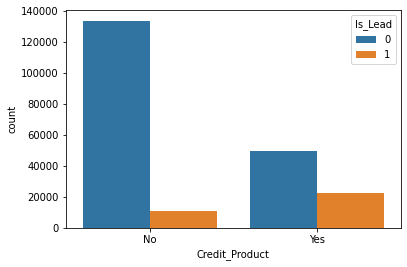

In [ ]:
sns.countplot(x='Credit_Product', hue=TARGET_NAME, data=train_df)
plt.show()

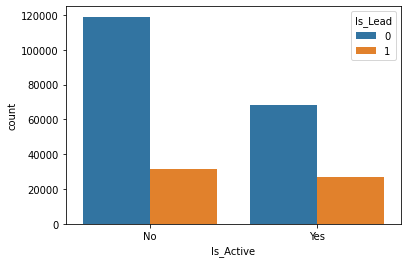

In [ ]:
sns.countplot(x='Is_Active', hue=TARGET_NAME, data=train_df)
plt.show()

In [ ]:
pay1_and_target_s = train_df.loc[train_df['Channel_Code'].isin(['X2', 'X4']), ['ID', 'Channel_Code', TARGET_NAME]].sample(50000)
table = pay1_and_target_s.pivot_table(values='ID', index='Channel_Code', columns=TARGET_NAME, aggfunc='count')
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p > 0.05
# do not union

False

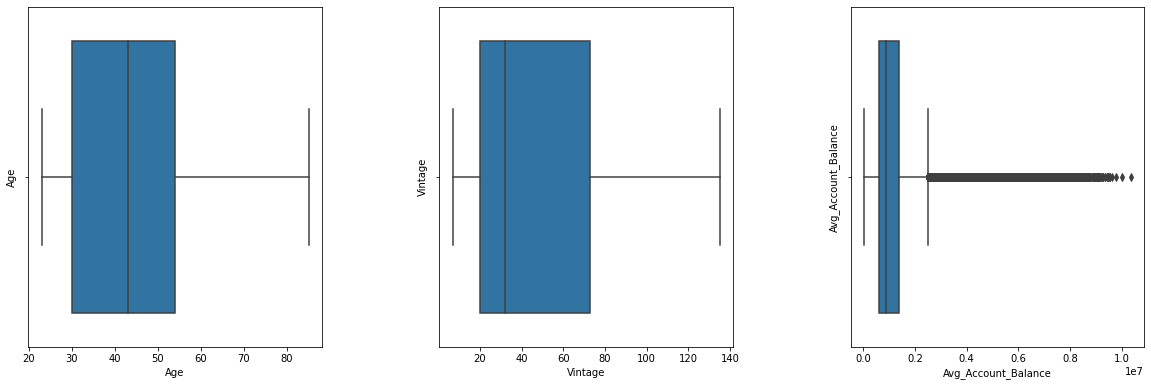

In [ ]:
plt.figure(figsize=(20, 15))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns[:-1]
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    sns.boxplot(train_df[col])
    plt.ylabel(col)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

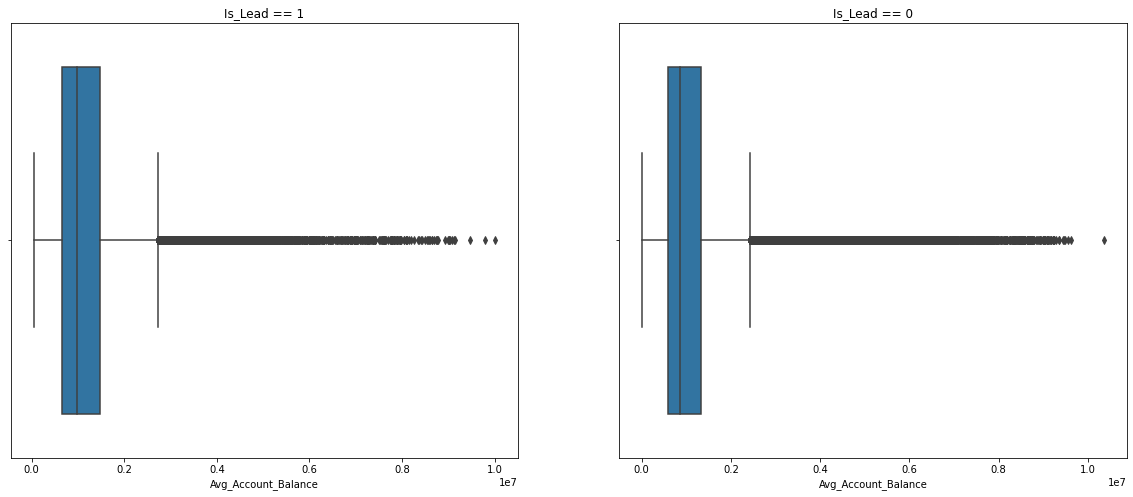

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.title(f'{TARGET_NAME} == 1')
sns.boxplot(x=train_df.loc[train_df[TARGET_NAME] == 1, 'Avg_Account_Balance'])
plt.subplot(122)
plt.title(f'{TARGET_NAME} == 0')
sns.boxplot(x=train_df.loc[train_df[TARGET_NAME] == 0, 'Avg_Account_Balance'])
plt.show()

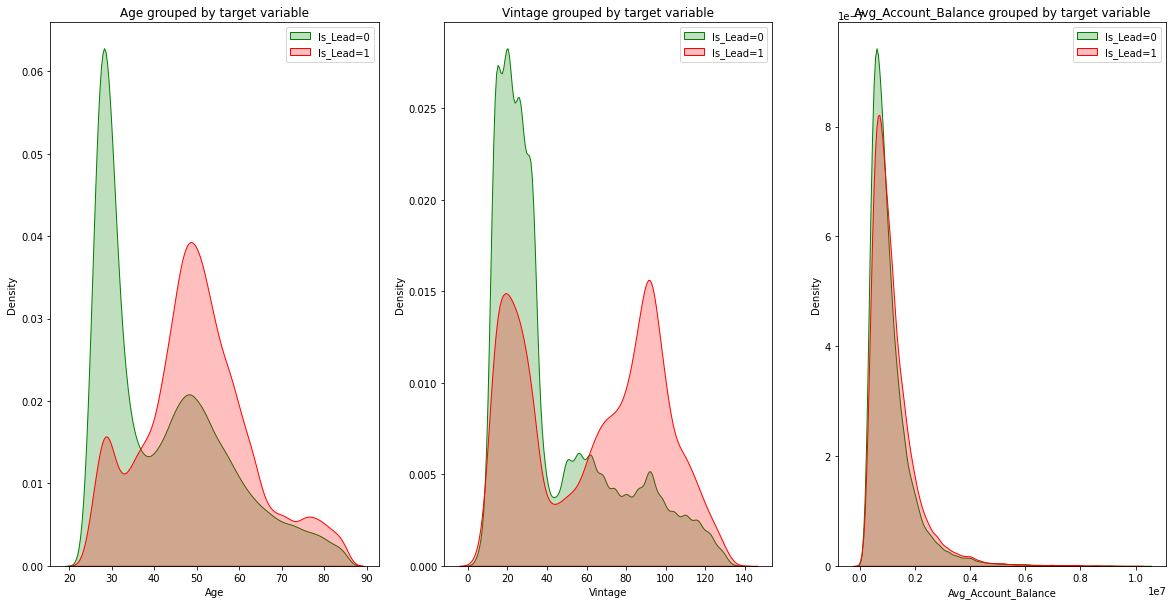

In [ ]:
plt.figure(figsize=(20, 10))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, idx)
    feature_with_target_s = train_df[[col, TARGET_NAME]]
    feature_s = feature_with_target_s[col]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]

    sns.kdeplot(feature_target_0, shade=True, label='Is_Lead=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Is_Lead=1', color='r')
    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.legend(loc='best')
plt.show()

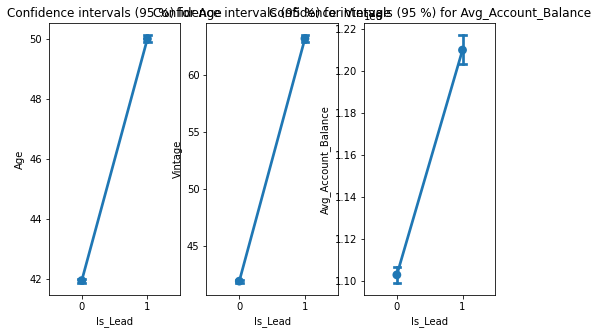

In [ ]:
plt.figure(figsize=(8, 5))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, idx)
    to_plot = train_df[[col, TARGET_NAME]]
    sns.pointplot(x=TARGET_NAME, y=col, data=to_plot, capsize=.1)
    plt.title(f'Confidence intervals (95 %) foheatmar {col}')
plt.show()

In [ ]:
# as if features have not normal distribution
for idx, column in enumerate(numeric_cols, 1):
    feature_with_target_s = train_df[[column, TARGET_NAME]] 
    feature_s = feature_with_target_s[column]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]
    mw = mannwhitneyu(feature_target_0, feature_target_1)
    imp = np.where(mw.pvalue < 0.05, 'usefull', 'useless') 
    if imp == 'usefull' and shapiro(feature_s.dropna())[1] < 0.05:  
        print(f'{idx}) {column}, p-value: {mw.pvalue}, feature is {imp}')
    else:
        print('='*45)
# something wrong - p-value == 0, but it is ibvious that featueres are usefull

1) Age, p-value: 0.0, feature is usefull
2) Vintage, p-value: 0.0, feature is usefull
3) Avg_Account_Balance, p-value: 0.0, feature is usefull


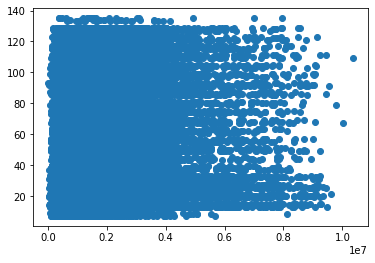

In [ ]:
plt.scatter(train_df['Avg_Account_Balance'], train_df['Vintage'])
plt.show()

In [ ]:
scan = DBSCAN(eps=10000, min_samples=10, n_jobs=-1)
outliers = scan.fit_predict(train_df.Avg_Account_Balance.values.reshape(-1, 1))

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
461,BDHVFC2R,Male,41,RG283,Other,X2,19,No,7880380,Yes,0
1145,SQZAMYSZ,Female,59,RG268,Self_Employed,X3,50,No,8256124,No,0
4126,CQEUBFEL,Male,27,RG254,Salaried,X1,25,No,7222955,No,0
5560,FG53BJUA,Male,50,RG284,Other,X2,38,No,7663879,Yes,0
5695,B8RM7ARY,Male,26,RG254,Other,X1,20,No,7575083,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...
242717,XMMLMVTI,Female,28,RG284,Other,X1,20,Yes,9039459,No,0
242889,AZXSSTEU,Female,47,RG284,Self_Employed,X2,25,Yes,8183118,No,0
243818,ARV9RJEQ,Female,66,RG283,Other,X3,109,Yes,8435295,No,1
245365,BDQF8JKD,Female,25,RG254,Other,X1,15,No,9279729,Yes,0


In [ ]:
serie_avg = train_df[outliers == -1].Avg_Account_Balance.nlargest(10)
train_df[train_df.Avg_Account_Balance.isin(serie_avg)]

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
64614,Y9D9TTW9,Male,44,RG268,Entrepreneur,X2,86,Yes,9459897,No,1
69209,RRTDA8LK,Male,53,RG268,Entrepreneur,X3,79,Yes,9792796,Yes,1
124356,N6YFDSBJ,Male,65,RG268,Other,X3,109,Yes,10352009,Yes,0
138374,9XXCMVAQ,Male,44,RG283,Entrepreneur,X1,67,Yes,10007678,No,1
151071,YKHWNNRR,Male,27,RG283,Salaried,X1,20,No,9352722,No,0
186307,4MBDPVWL,Male,30,RG283,Salaried,X1,21,No,9614883,No,0
195105,AXRKAWCF,Female,79,RG268,Other,X3,91,Yes,9546317,No,0
198862,FFSRXME2,Female,27,RG254,Other,X1,25,No,9459071,Yes,0
218328,BURACVLV,Male,85,RG254,Other,X3,111,No,9438239,Yes,0
245701,BG6UHJTS,Male,32,RG277,Salaried,X1,13,Yes,9491986,No,0


In [ ]:
q1, q3 = np.quantile(train_df.Avg_Account_Balance, q=0.25), np.quantile(train_df.Avg_Account_Balance, q=0.75)
q3 + 1.5 * (q3 - q1)
# Balance -> np.log, because not big enough outlier value
# isSusp feature

2510200.0

In [ ]:
train_df[train_df.Avg_Account_Balance > 7e+6] # random +/- std bad idea

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
461,BDHVFC2R,Male,41,RG283,Other,X2,19,No,7880380,Yes,0
1145,SQZAMYSZ,Female,59,RG268,Self_Employed,X3,50,No,8256124,No,0
1827,553PF9ZU,Female,29,RG254,Salaried,X3,20,NaN,7414269,Yes,1
2199,YV8H8SWW,Female,26,RG254,Salaried,X1,19,No,7138734,No,0
3801,SBDNWVZC,Male,36,RG268,Self_Employed,X2,37,Yes,7148942,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
242765,SAAMQ2BZ,Male,71,RG254,Other,X3,123,No,7903645,Yes,0
242889,AZXSSTEU,Female,47,RG284,Self_Employed,X2,25,Yes,8183118,No,0
243818,ARV9RJEQ,Female,66,RG283,Other,X3,109,Yes,8435295,No,1
245365,BDQF8JKD,Female,25,RG254,Other,X1,15,No,9279729,Yes,0


In [ ]:
q999 = np.quantile(train_df.Avg_Account_Balance, q=0.999)
tt_df = train_df.copy()
tt_df.loc[tt_df.Avg_Account_Balance > 7e+6, 'Avg_Account_Balance'] = q999
shapiro(np.log(tt_df.Avg_Account_Balance.values))[1]

0.0

In [ ]:
train_df.corr() # cannot calculate Balance using another feautures

,Age,Vintage,Avg_Account_Balance,Is_Lead
Age,1.000000,0.631242,0.145232,0.230814
Vintage,0.631242,1.000000,0.167433,0.279642
Avg_Account_Balance,0.145232,0.167433,1.000000,0.053370
Is_Lead,0.230814,0.279642,0.053370,1.000000


In [ ]:
train_df[train_df.Avg_Account_Balance > 6.1e+6]

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
113,JAS9QVTW,Female,27,RG268,Salaried,X1,21,No,6278683,Yes,0
461,BDHVFC2R,Male,41,RG283,Other,X2,19,No,7880380,Yes,0
826,XDU9VEFB,Female,67,RG268,Other,X3,55,No,6588376,Yes,0
1079,Q5N3G69P,Male,29,RG254,Self_Employed,X1,26,No,6722899,Yes,0
1145,SQZAMYSZ,Female,59,RG268,Self_Employed,X3,50,No,8256124,No,0
...,...,...,...,...,...,...,...,...,...,...,...
243818,ARV9RJEQ,Female,66,RG283,Other,X3,109,Yes,8435295,No,1
244971,TN8WEQTV,Female,28,RG268,Salaried,X1,33,No,6247755,No,0
245365,BDQF8JKD,Female,25,RG254,Other,X1,15,No,9279729,Yes,0
245653,UKT5GX45,Male,46,RG257,Self_Employed,X1,26,Yes,6900312,No,1


In [ ]:
tr = PowerTransformer(method='box-cox')
train_df.loc[:, ['Age', 'Vintage', 'Avg_Account_Balance']] = tr.fit_transform(train_df[['Age', 'Vintage', 'Avg_Account_Balance']].values)
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,1.626065,RG268,Other,X3,0.253251,No,0.239639,No,0
1,IDD62UNG,Female,-0.975206,RG277,Salaried,X1,-0.165487,No,-0.728404,No,0
2,HD3DSEMC,Female,0.913381,RG268,Self_Employed,X3,-0.467170,No,0.787816,Yes,0
3,BF3NC7KV,Male,-0.571142,RG270,Salaried,X1,-0.934807,No,-1.096364,No,0
4,TEASRWXV,Female,-0.975206,RG282,Salaried,X1,-0.121303,No,-0.026086,No,0


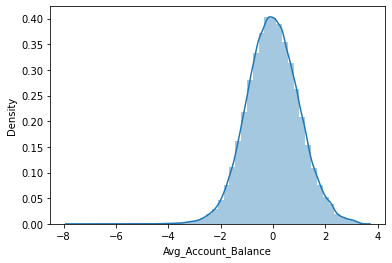

In [ ]:
sns.distplot(train_df.Avg_Account_Balance)

In [ ]:
shapiro(train_df.Avg_Account_Balance) # now normal distribution

(0.9987974762916565, 1.406986069634453e-32)

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
def cross_validation(clf, X, y):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='f1', n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def plot_cm_val(y_true, y_pred, X, y, estimator):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    conf_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])
    scores = np.array(cross_validation(estimator, X, y))
    print('\n')
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    sns.heatmap(conf_df, cmap="Oranges", annot=True, annot_kws={"size": 16}, fmt='d')
    plt.title('Confusion matrix for test')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.subplot(122)
    plt.plot(scores, c='g', linestyle=':', label='Cross Validation Scores', marker='*')
    plt.fill_between(np.arange(scores.shape[0]), scores.mean() - scores.std(), scores.mean() + scores.std(), alpha=0.3)
    plt.axhline(0.5, c='r', linestyle='--', label='min f1_score')
    plt.axhline(scores.mean(), c='b', linestyle='-.', label='score mean')
    plt.legend(loc='best')
    plt.ylim([0.47, max(scores) + 0.1])
    plt.xticks(np.arange(scores.shape[0]))
    plt.grid()
    plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    roc_train, roc_test = roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)
    print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}') # weighted?
    print(f'Train GINI: {(2 * roc_train - 1):.3f}, Test GINI: {(2 * roc_test - 1):.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def custom_oversampling(df, target_name=TARGET_NAME, delimiter=0):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_clss_name = target_counts.argmin()
    disbalance_coef = int(target_counts[major_class_name] / target_counts[minor_clss_name]) - 1
    for i in range(disbalance_coef - delimiter):
        sample = df[df[target_name] == minor_clss_name].sample(target_counts[minor_clss_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote


In [ ]:
class Preprocessor:
    def __init__(self, with_cat=False, target=TARGET_NAME, power=True):
        self.with_cat = with_cat
        self.target = target
        self.power = power
        self.prob_dict = {}
        self.region_woe_vocab = {}
        self.occupation_woe_vocab = {}
        self.smooth = {}
        self.transformer = PowerTransformer(method='box-cox')
        self.agg_age_vint = None
        self.agg_age_vint_median = None
        self.agg_age_occ = None
        self.agg_age_occ_median = None
        self.reg_ch_bal = None
        self.reg_ch_bal_mean = None
        self.age_vint_tar = None
        self.credit_vocab = {}

    def fit(self, df):
        prob = df.groupby(['Region_Code'])[self.target].mean()
        prob_df = pd.DataFrame(prob)
        prob_df['Not_Is_Lead'] = 1 - prob_df[self.target]
        prob_df['Ratio'] = prob_df[self.target] / prob_df['Not_Is_Lead']
        self.prob_dict = prob_df['Ratio'].to_dict()

        emb_count_0 = df.loc[df[self.target] == 0, 'Region_Code'].count()
        emb_count_1 = df.loc[df[self.target] == 1, 'Region_Code'].count()

        for item in df.Region_Code.unique():
            percent_non_event = df.loc[((df[self.target] == 0) & (df.Region_Code == item)), 'Region_Code'].count() / emb_count_0
            percent_event = df.loc[((df[self.target] == 1) & (df.Region_Code == item)), 'Region_Code'].count() / emb_count_1
            self.region_woe_vocab[item] = np.log(percent_non_event / percent_event) # WOE
            # self.vocab[item] = (percent_non_event - percent_event) * woe # IV

        emb_count_0 = df.loc[df[self.target] == 0, 'Occupation'].count()
        emb_count_1 = df.loc[df[self.target] == 1, 'Occupation'].count()

        for item in df.Occupation.unique():
            percent_non_event = df.loc[((df[self.target] == 0) & (df.Occupation == item)), 'Occupation'].count() / emb_count_0
            percent_event = df.loc[((df[self.target] == 1) & (df.Occupation == item)), 'Occupation'].count() / emb_count_1
            self.occupation_woe_vocab[item] = np.log(percent_non_event / percent_event) 

        mean = df[self.target].mean()
        agg = df.groupby('Channel_Code')[self.target].agg(['count', 'mean'])
        counts, means, weight = agg['count'], agg['mean'], 100
        self.smooth = (counts * means + weight * mean) / (counts + weight)  

        self.transformer.fit(df[['Age', 'Vintage', 'Avg_Account_Balance']])  # calculate lambdas_

        return df

    def __call__(self, df):
        if self.target in df.columns:
            df = self.fit(df)
        df = self.transform(df)
        df = self.create_features(df)
        df = self.reduce_memory(df)
        return df
    
    def transform(self, df):
        # drop dublicates
        df.drop_duplicates(inplace=True)

        # remove ID
        df = df.drop('ID', axis=1)

        # Age: stay / np.log
        # df.Age = np.log(df.Age)

        # fillna Credit_Product
        df.Credit_Product.fillna('Unknown', inplace=True)

        if not self.with_cat:
            # Gender - binary encoding
            df.Gender = df.Gender.map({'Female': 0, 'Male': 1})

            # Region_code: probability encoding
            df.Region_Code = df.Region_Code.map(self.prob_dict)

            # Occupation: weight of evidence encoding
            df.Occupation = df.Occupation.map(self.occupation_woe_vocab)

            # Channel_code: smooth encoding
            df.Channel_Code = df.Channel_Code.map(self.smooth)

            # Credit_product: one-hot encoding / WoE
            credit_dummy = pd.get_dummies(df.Credit_Product)  # if drop_first=True there may be lost of info in feature selector
            dummy_size = credit_dummy.shape[1]
            df = pd.concat([df, credit_dummy], axis=1)
            del credit_dummy
            df.iloc[:, -dummy_size] = df.iloc[:, -dummy_size].astype(np.uint8)
            df.drop('Credit_Product', axis=1, inplace=True)

            # Is_Active: binary encoding
            df.Is_Active = df.Is_Active.map({'No': 0, 'Yes': 1})

        else:
            # one_hot_max_size = 5
            # Region_code WoE
            df.Region_Code = df.Region_Code.map(self.region_woe_vocab)

        # Avg_Account_Balance: np.log to get closer to normal distribution and robust possible outliers, goof for linear models
        # isSusp to mark possible outliers
        df['isSusp'] = 0
        df.loc[df.Avg_Account_Balance > 4.5e+6, 'isSusp'] = 1

        if not self.power:
            df.Avg_Account_Balance = np.log(df.Avg_Account_Balance)
            # Vintage: no transform
        else:
            # transform features to normal distribution
            df.loc[:, ['Age', 'Vintage', 'Avg_Account_Balance']] = self.transformer.transform(df[['Age', 'Vintage', 'Avg_Account_Balance']].values)

        return df

    def create_features(self, df):
        # multiple or single groups on means of numerical columns, target counts - 3 features
        # 1) Age Vintage to target mean
        if self.target in df.columns:
            self.agg_age_vint = df.groupby(['Age', 'Vintage'], as_index=False)[self.target].agg('mean')
            self.agg_age_vint.columns = ['Age', 'Vintage', 'AVT']
            self.agg_age_vint_median = self.agg_age_vint.AVT.median()
        df = df.merge(self.agg_age_vint, on=['Age', 'Vintage'], how='left')
        df.AVT.fillna(self.agg_age_vint_median, inplace=True)

        # 2) Age Occupation to target mean
        if self.with_cat:
            df['OCC'] = df.Occupation.map(self.occupation_woe_vocab)
            if self.target in df.columns:
                self.agg_age_occ = df.groupby(['Age', 'OCC'], as_index=False)[self.target].agg('mean')
                self.agg_age_occ.columns = ['Age', 'OCC', 'AOT']
                self.agg_age_occ_median = self.agg_age_vint.AVT.median()
            df = df.merge(self.agg_age_occ, on=['Age', 'OCC'], how='left')
            df.AOT.fillna(self.agg_age_occ_median, inplace=True)
            df = df.drop('OCC', axis=1)
        else:
            if self.target in df.columns:
                self.agg_age_occ = df.groupby(['Age', 'Occupation'], as_index=False)[self.target].agg('mean')
                self.agg_age_occ.columns = ['Age', 'Occupation', 'AOT']
                self.agg_age_occ_median = self.agg_age_vint.AVT.median()
            df = df.merge(self.agg_age_occ, on=['Age', 'Occupation'], how='left')
            df.AOT.fillna(self.agg_age_occ_median, inplace=True)
        
        # 3) Region_Code Channel_Code to Balance mean
        if self.with_cat:
            df['CH'] = df.Channel_Code.map(self.smooth)
            if self.target in df.columns:
                self.reg_ch_bal = df.groupby(['Region_Code', 'CH'], as_index=False)['Avg_Account_Balance'].agg('mean')
                self.reg_ch_bal.columns = ['Region_Code', 'CH', 'AVM']
                self.reg_ch_bal_mean = self.reg_ch_bal.AVM.mean()
            df = df.merge(self.reg_ch_bal, on=['Region_Code', 'CH'], how='left')
            df.AVM.fillna(self.reg_ch_bal_mean, inplace=True)
            df = df.drop('CH', axis=1)
        else:
            if self.target in df.columns:
                self.reg_ch_bal = df.groupby(['Region_Code', 'Channel_Code'], as_index=False)['Avg_Account_Balance'].agg('mean')
                self.reg_ch_bal.columns = ['Region_Code', 'Channel_Code', 'AVM']
                self.reg_ch_bal_mean = self.reg_ch_bal.AVM.mean()
            df = df.merge(self.reg_ch_bal, on=['Region_Code', 'Channel_Code'], how='left')
            df.AVM.fillna(self.reg_ch_bal_mean, inplace=True)
        
        # 4) look for external real-world data

        return df

    @staticmethod
    def sampling(X, y, method='combine', delimiter=0):
        # Tomek, custom + SMOTE, SMOTENC + custom
        counts_start = Counter(y)
        print(f'Inintial class labels ratio: {dict(counts_start)}')
        if method == 'combine':
            sampler = SMOTETomek(sampling_strategy=0.35, random_state=1)  # use 'balanced' while training
            X, y = sampler.fit_sample(X, y) 
        elif method == 'custom': # generates dublicates a lot
            df = pd.concat([X, y], axis=1)
            X = custom_oversampling(df, delimiter=delimiter)
            y = X[TARGET_NAME]
            X = X.drop(TARGET_NAME, axis=1)
            under = RandomUnderSampler(sampling_strategy=0.75, replacement=True, random_state=1)
            X, y = under.fit_resample(X, y)
        elif method == 'category':
            categorical_cols = X.select_dtypes(['category', 'object', 'int8']).columns
            cat_idxs = [i for i, col in enumerate(X.columns) if col in categorical_cols]
            gen = SMOTENC(categorical_features=cat_idxs, sampling_strategy=0.35, random_state=1)  # 0.5
            X, y = gen.fit_resample(X, y)
            under = RandomUnderSampler(sampling_strategy=0.4, replacement=True, random_state=1)  # 0.75
            X, y = under.fit_resample(X, y)
        elif method == 'simple_custom':
            df = pd.concat([X, y], axis=1)
            X = custom_oversampling(df, delimiter=delimiter)
            y = X[TARGET_NAME]
            X = X.drop(TARGET_NAME, axis=1)
        else: 
            raise ValueError(f'Method should be "combine", "custom" or "custom_nc", given: {method}')
        counts_end = Counter(y)
        print(f'Final class labels ratio: {dict(counts_end)}')
        return X, y   
        
    
    @staticmethod
    def reduce_memory(df):
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object and str(col_type)[:4] != 'uint':
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            elif str(col_type)[:4] != 'uint':
                df[col] = df[col].astype('category')
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        return df
# reduce dimensionality by PCA, LDA, t-SNE, AoutoEncoder
# in churn may use previous payments in sample with weighted rolling sum

In [ ]:
train_df = pd.read_csv(train_path)
train_df, test_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=1)
test_df, test_targets = test_df.drop(TARGET_NAME, axis=1), test_df[TARGET_NAME]
preprocessor = Preprocessor(with_cat=False)
train_df = preprocessor(train_df)
test_df = preprocessor(test_df)

Memory usage of dataframe is 24.25 MB
Memory usage after optimization is: 10.76 MB
Decreased by 55.7%
Memory usage of dataframe is 2.51 MB
Memory usage after optimization is: 1.17 MB
Decreased by 53.3%


In [ ]:
train_df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,No,Unknown,Yes,isSusp,AVT,AOT,AVM
0,0,-0.867226,0.268708,0.491497,0.091433,-0.120632,-0.348516,0,0,1,0,0,0,0.071918,0.088590,0.414310
1,0,0.352856,0.200909,-0.204495,0.091433,-0.933801,-0.846414,0,0,1,0,0,0,0.372093,0.310253,-0.332152
2,0,-0.974501,0.238181,0.491497,0.091433,-0.164790,-0.595117,0,0,1,0,0,0,0.081034,0.086969,-0.468656
3,1,1.763759,0.285162,-0.039912,0.091433,-1.403196,-0.744632,0,0,1,0,0,0,0.230769,0.311725,-0.267016
4,0,-1.325628,0.201854,-0.204495,0.091433,-1.403196,-1.645524,0,0,1,0,0,0,0.059159,0.054101,-0.121466


In [ ]:
X, y = train_df.drop(TARGET_NAME, axis=1), train_df[TARGET_NAME]
# it is useful to predict probas to find out wich users have the most probability to lead (or churn)

In [ ]:
# poly = PolynomialFeatures(degree=3)  # reverse operation for numeric features - pca, lda decomposition
# X = poly.fit_transform(X)
# f1 increases up from 0.668 to 0.677 but calculating time is discouraging because of more than 800 features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
# X_train, y_train = preprocessor.sampling(X_train, y_train, method='combine')
"""
when making cross-validation: use pipeline to prevent data leakage
because when taking just train set, that was sampled and scaled we automaticaly apply these
transformations to every fold which leeds to incorrect results
pipeline comes in hande here. It is sampling and scaling only the training part but not fold (test)
"""

In [ ]:
# MaxAbsScaler to fit sparse data, RobustScaler (medians) to fit data with outliers
# MinMaxScaler - scales data 0..1
# StandardScaler - good for data with gaussian distribution, scales with mean = 0, and std=1
# If the distribution of the quantity is normal, then it should be standardized, 
# otherwise, the data should be normalized.
base = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=100.0, tol=1e-4, # C=1000.0
                          max_iter=500, class_weight='balanced'))
base.fit(X_train, y_train)
y1 = base.predict(X_train)
y2 = base.predict(X_test)
report(y_train, y1, y_test, y2)
# no sampling needed for base... sampling leeds to overfitting

Train
               precision    recall  f1-score   support

           0      0.921     0.838     0.877    118050
           1      0.596     0.770     0.672     36756

    accuracy                          0.821    154806
   macro avg      0.759     0.804     0.775    154806
weighted avg      0.844     0.821     0.829    154806

Test
               precision    recall  f1-score   support

           0      0.919     0.838     0.876     50593
           1      0.594     0.763     0.668     15753

    accuracy                          0.820     66346
   macro avg      0.757     0.801     0.772     66346
weighted avg      0.842     0.820     0.827     66346

Train ROC_AUC: 0.804, Test ROC_AUC: 0.801
Train GINI: 0.607, Test GINI: 0.601
Confusion Matrix 
 col_0        0      1
Is_Lead              
0        42375   8218
1         3726  12027


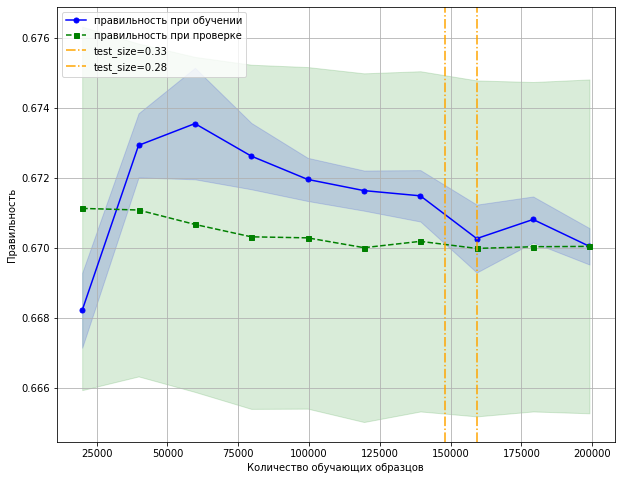

In [ ]:
estimator = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced'))
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='f1', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X.shape[0]*0.72, color='orange', linestyle='-.', label='test_size=0.28')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# оптимальный test_size=0.28

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, shuffle=True, stratify=y, random_state=1)

In [ ]:
# Feature importancies

In [ ]:
# Information gain: mutual info
mutual_vector = mutual_info_classif(X, y, random_state=1)
mutual_dict = dict(zip(X.columns, mutual_vector))
for col, vec in sorted(mutual_dict.items(), key=lambda x: x[1], reverse=True):
    print(f'{col} -> {vec}')

No -> 0.12484917799505557
Unknown -> 0.12092658719665184
AOT -> 0.07567914004293397
AVT -> 0.07417873894168414
AVM -> 0.052158557847596265
Age -> 0.05044035825311055
Channel_Code -> 0.04935395797374742
Vintage -> 0.04670577840405743
Gender -> 0.012722194289814581
Occupation -> 0.012071782910200612
Is_Active -> 0.008192898010991767
Region_Code -> 0.008150678396259714
Yes -> 0.00795323866037867
Avg_Account_Balance -> 0.006694316650025511
isSusp -> 0.0008063795791080075


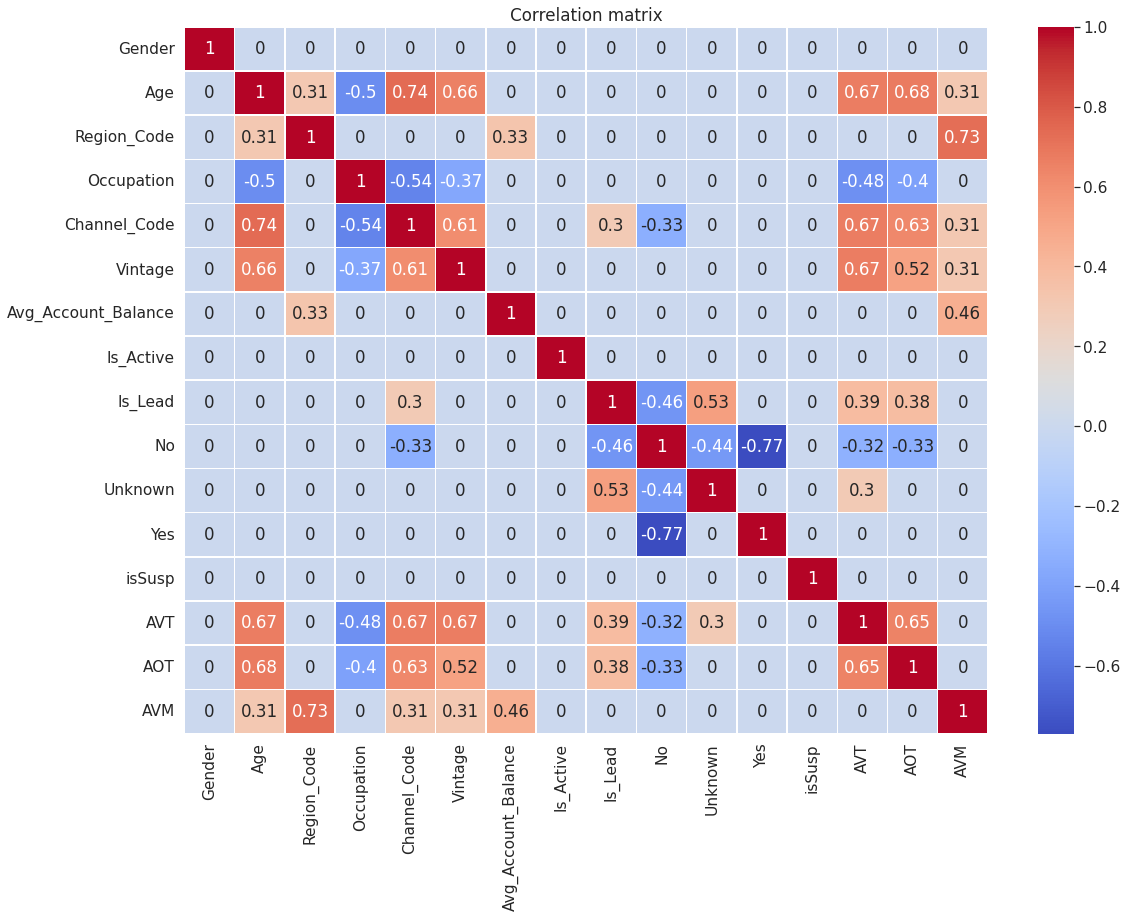

In [ ]:
# correlation matrix: choose ones that mostly correlated to target and discard mostly correlated with each other
plt.figure(figsize = (18,13))
sns.set(font_scale=1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

1) Unknown	0.6238192043121602
2) AVT	0.10885839132737976
3) No	0.07457822231915585
4) Yes	0.06863716316045555
5) AOT	0.0684229055762353
6) Is_Active	0.01819606630096608
7) Avg_Account_Balance	0.011323267236143877
8) Vintage	0.006691122209931903
9) Age	0.005323671721092204
10) Occupation	0.004794249539205394
11) Channel_Code	0.003579505263366137
12) AVM	0.00303972942530162
13) Region_Code	0.0021277169445052396
14) Gender	0.0006057971560281001
15) isSusp	2.9875080729612852e-06


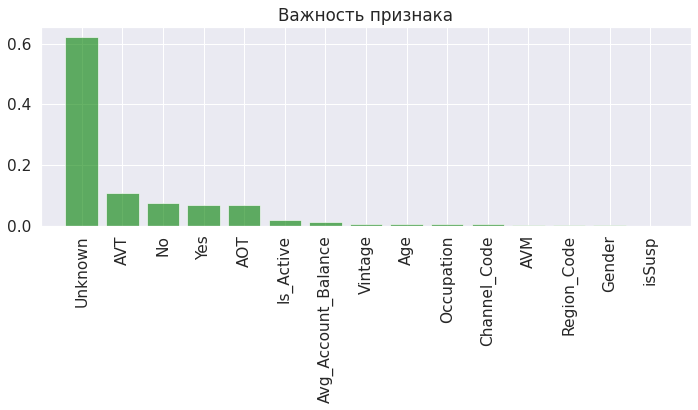

In [ ]:
# importancies with rf: choose features that mostly decrease the loss during splitting nodes
# importancies with gb: choose features that most frequently used in splitting process
from sklearn.ensemble import GradientBoostingClassifier as GBC
boost = GBC(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=1)
boost.fit(X, y)
feat_labels = np.array(train_df.drop(TARGET_NAME, axis=1).columns)
importances = boost.feature_importances_
indices = np.argsort(importances)[::-1]
for x in range(X.shape[1]):
    print(f'{x+1}) {feat_labels[indices[x]]}\t{importances[indices[x]]}')
plt.figure(figsize=(10, 6))
plt.title('Важность признака')
plt.bar(range(X.shape[1]), importances[indices], align='center', alpha=0.6, color='green')
plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159229 entries, 169102 to 86916
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               159229 non-null  int8   
 1   Age                  159229 non-null  float32
 2   Region_Code          159229 non-null  float32
 3   Occupation           159229 non-null  float32
 4   Channel_Code         159229 non-null  float32
 5   Vintage              159229 non-null  float32
 6   Avg_Account_Balance  159229 non-null  float32
 7   Is_Active            159229 non-null  int8   
 8   No                   159229 non-null  uint8  
 9   Unknown              159229 non-null  uint8  
 10  Yes                  159229 non-null  uint8  
 11  isSusp               159229 non-null  int8   
 12  AVT                  159229 non-null  float32
 13  AOT                  159229 non-null  float32
 14  AVM                  159229 non-null  float32
dtypes: float32(9)

In [ ]:
# Chi-square Test
from sklearn.feature_selection import SelectKBest, chi2
chi2_features = SelectKBest(chi2, k=3)
X_kbest = chi2_features.fit_transform(X_train.select_dtypes(['uint8', 'int8']), y_train)
# took 3 best categorical features

In [ ]:
# Fisher’s Score: ranks of features 

In [ ]:
# Variance Threshold
from sklearn.feature_selection import VarianceThreshold
v_thres = VarianceThreshold(threshold=0.15)
v_thres.fit(X_train)

VarianceThreshold(threshold=0.15)

In [ ]:
res_tresh = [item for idx, item in enumerate(X_train.columns) if  v_thres.get_support()[idx]]
print(*res_tresh, sep=', ')

Gender, Age, Vintage, Avg_Account_Balance, Is_Active, No, Yes, AVM


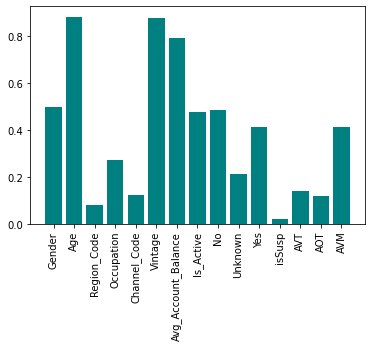

In [ ]:
# Mean Absolute Difference (MAD)
means_abs_diff = np.sum(np.abs(X_train - np.mean(X_train, axis=0)), axis=0) / X_train.shape[0]
plt.bar(X_train.columns, means_abs_diff, color='teal')
plt.xticks(rotation=90)
plt.show()

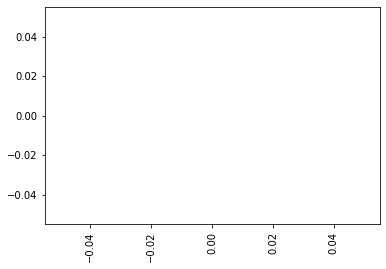

In [ ]:
# Dispersion ratio
X_train_ = X_train.copy() + 1
am = np.mean(X_train_, axis=0)
gm = np.power(np.prod(X_train_, axis=0), 1 / X_train_.shape[0])
disp_ratio = am / gm
plt.bar(X_train.columns, disp_ratio, color='teal')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Forward Feature Selection
# starts with 0 features and adds one by one until best subset found
# if forward=False - starts with all features and discards one by one until best subset
from mlxtend.feature_selection import SequentialFeatureSelector
ffs = SequentialFeatureSelector(estimator, k_features='best', forward=True, n_jobs=-1)
ffs.fit(X_train, y_train)

In [ ]:
ffs.k_feature_names_

('Occupation', 'Unknown')

In [ ]:
# Stepwise-selection, see also mannwhitney above
import statsmodels.api as sm

model = sm.OLS(y_train, sm.add_constant(X_train.values))
res = model.fit()

In [ ]:
res.pvalues

const     8.797244e-01
x1        2.511808e-01
x2       9.212896e-198
x3        1.325008e-01
x4       6.496163e-163
x5        7.124107e-02
x6        2.553475e-05
x7        1.971169e-03
x8        4.207051e-56
x9        8.797244e-01
x10       8.797244e-01
x11       8.797244e-01
x12       4.360821e-02
x13       0.000000e+00
x14       0.000000e+00
x15       1.012952e-06
dtype: float64

In [ ]:
# Exhaustive Feature Selection - tries all subsets and returns best
from mlxtend.feature_selection import ExhaustiveFeatureSelector
efs = ExhaustiveFeatureSelector(estimator, min_features=10, max_features=X_train.shape[1], scoring='f1', cv=2)
efs.fit(X_train, y_train)
# efs.best_idx_, efs.best_score_

In [ ]:
# Recursive Feature Elimination, disadvantage - we have to assign number of desired features in advance
from sklearn.feature_selection import RFE
rfe = RFE(estimator, n_features_to_select=12)
rfe.fit(X_train, y_train)
pr = rfe.predict(X_train) # get column indicies

In [ ]:
# LASSO Regularization (L1)/ see also real_estate_....ipynb
from sklearn.feature_selection import SelectFromModel  # see also SelectPercentile
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5, max_features=X.shape[1], n_jobs=-1,
                            random_state=1, class_weight='balanced', min_samples_leaf=1)
rf.fit(X_train, y_train)
model = SelectFromModel(rf, prefit=True)
X_new = model.transform(X_train)

In [ ]:
res = [item for idx, item in enumerate(X_train.columns) if model.get_support()[idx]]
print(*res, sep=', ')

No, Yes, AVT


In [ ]:
# Genetic Algorithms (GA)
import random

def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    for chromosome in population:
        estimator.fit(X_train.iloc[:,chromosome],y_train)
        predictions = estimator.predict(X_test.iloc[:,chromosome])
        scores.append(f1_score(y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print(scores[:2])
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo, best_score

In [ ]:
chromo, score = generations(size=200, n_feat=15, n_parents=100, mutation_rate=0.10,
                            n_gen=38, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [ ]:
estimator.fit(X_train.iloc[:,chromo[-1]], y_train)
predictions = estimator.predict(X_test.iloc[:,chromo[-1]])
print("F1 score after genetic algorithm is= "+str(f1_score(y_test, predictions)))
print('list of important features', X_train.iloc[:, chromo[-1]].columns)

F1 score after genetic algorithm is= 0.6631526252245354
list of important features Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'No',
       'Yes', 'AVT', 'AOT'],
      dtype='object')


In [ ]:
# класс, который выбирает наилучший поднабор признаков, исходя из заданной метрики
# as alternative use sklearn feature selectors
class ChooseBestSubset:
    def __init__(self, estimator, k_features, scoring='f1_score', test_size=0.25, random_state=1):
        self.scoring = str(scoring)
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        if (self.scoring == 'f1_score') or (self.scoring == 'accuracy_score'):
            self.scoring = eval(self.scoring)
        else:
            raise ValueError(f'Метрика должна быть "f1_score" или "accuracy_score", дана: {self.scoring}')
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, stratify=y, shuffle=True,
                                                           random_state=self.random_state)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_) # сначала для полного набора
        self.scores_ = [score]
        while dim > self.k_features: # цикл до тех пор, пока не будет наименее короткий заданный набор
            scores, subsets = [], []
            sys.stderr.write(f'Анализ наборов признаков {dim}/{X_train.shape[1]}, осталось {dim - self.k_features}:')
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim): # проверяем различные комбинации признаков 
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score) # записываем score текущего набора
                subsets.append(p) # записываем значения индексов текущего набора
            clear_output(wait=True)
            best = np.argmax(scores) # находим лучший набор
            self.indices_ = subsets[best] # сохраняем значения индексов лучшего набора из текущей итерации while
            self.subsets_.append(self.indices_) # сохраняем лучший набор из текущей итерации while
            dim -= 1
            self.scores_.append(scores[best]) # сохраняем лучшее значение метрики на текущей итерации
        self.k_score_ = self.scores_[-1] # scores для последнего набора = k_features
        return self
    def _calc_score(self, X_train, y_train, X_test, y_test, indices): # вычисляем метрику набора
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
selector = ChooseBestSubset(estimator, k_features=10, test_size=0.28)
selector.fit(X.values, y)

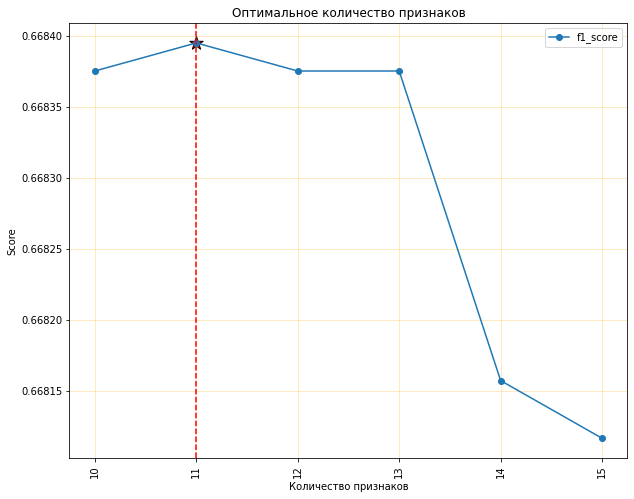

In [ ]:
k_feat = [len(k) for k in selector.subsets_] # вычисляем длины наборов
plt.figure(figsize=(10, 8))
plt.plot(k_feat, selector.scores_, marker='o', label='f1_score')
plt.scatter(k_feat[np.argmax(np.array(selector.scores_))], max(selector.scores_), marker='*', color='red', 
              ec='black', s=200)
plt.axvline(k_feat[np.argmax(np.array(selector.scores_))], color='red', linestyle='--')
plt.title('Оптимальное количество признаков')
plt.ylabel('Score')
plt.xlabel('Количество признаков')
plt.xticks(k_feat, rotation=90)
plt.legend(loc='best')
plt.grid(color='orange', alpha=0.3) # из-за вывода матрицы корреляции с заданным стилем уходит сетка
plt.show()

In [ ]:
columns = train_df.columns[train_df.columns != TARGET_NAME]
cols = [columns[i] for i in selector.subsets_[np.argmax(np.array(selector.scores_))]]
cols += [TARGET_NAME]
df_selected_cbs = train_df[[*cols]]
df_selected_cbs.head(1)

,Gender,Age,Occupation,Channel_Code,Is_Active,No,Unknown,isSusp,AVT,AOT,AVM,Is_Lead
0,0,-0.867226,0.491497,0.091433,0,1,0,0,0.071918,0.08859,0.41431,0


In [ ]:
X, y = df_selected_cbs.drop(TARGET_NAME, axis=1), df_selected_cbs[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, shuffle=True, stratify=y, random_state=1)

In [ ]:
# base + GridSearchCV
param_grid = [{'logisticregression__C': [0.1, 1., 10., 100., 1000., 10000.],
              'logisticregression__max_iter': [100, 200, 500, 1000],
               'logisticregression__tol': [1e-2, 1e-3, 1e-4]}]

In [ ]:
test_lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', class_weight='balanced'))
gs = GridSearchCV(estimator=test_lr, param_grid=param_grid, scoring='f1', cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print('правильность при испытании: %.3f' % f1_score(y_test, pred))

0.6718756888769369
{'logisticregression__C': 10.0, 'logisticregression__max_iter': 100, 'logisticregression__tol': 0.01}
правильность при испытании: 0.668


In [ ]:
base = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', 
                                                          class_weight='balanced', max_iter=100, C=10., tol=0.01))
base.fit(X_train, y_train)
base_train_pred = base.predict(X_train)
base_test_pred = base.predict(X_test)

In [ ]:
report(y_train, base_train_pred, y_test, base_test_pred)

Train
               precision    recall  f1-score   support

           0      0.921     0.838     0.878    121423
           1      0.596     0.770     0.672     37806

    accuracy                          0.822    159229
   macro avg      0.759     0.804     0.775    159229
weighted avg      0.844     0.822     0.829    159229

Test
               precision    recall  f1-score   support

           0      0.919     0.838     0.877     47220
           1      0.595     0.763     0.668     14703

    accuracy                          0.820     61923
   macro avg      0.757     0.800     0.773     61923
weighted avg      0.842     0.820     0.827     61923

Train ROC_AUC: 0.804, Test ROC_AUC: 0.800
Train GINI: 0.608, Test GINI: 0.601
Confusion Matrix 
 col_0        0      1
Is_Lead              
0        39578   7642
1         3487  11216


Меры правильности перекрекстной оценки: [0.66751298 0.67416773 0.67149758 0.66973215 0.66758116 0.67138055
 0.67066006 0.67991632 0.67460409 0.67170425]
Точность перекретсной оценки: 0.672 +/- 0.003




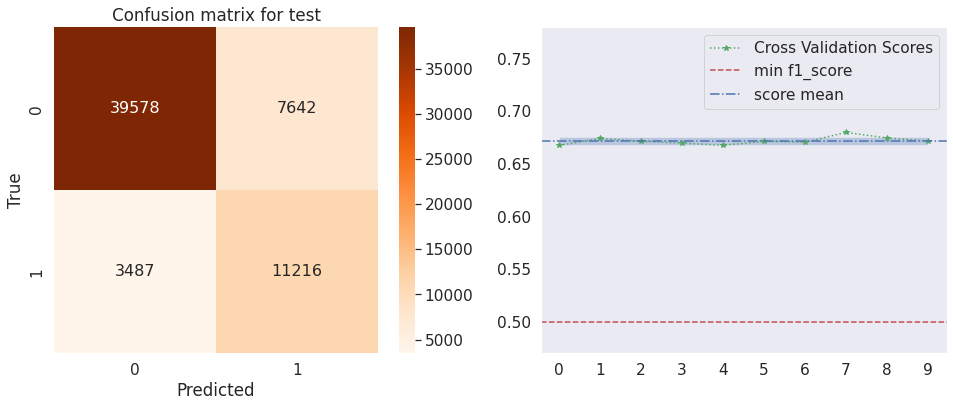

In [ ]:
plot_cm_val(y_test, base_test_pred, X_train, y_train, base)

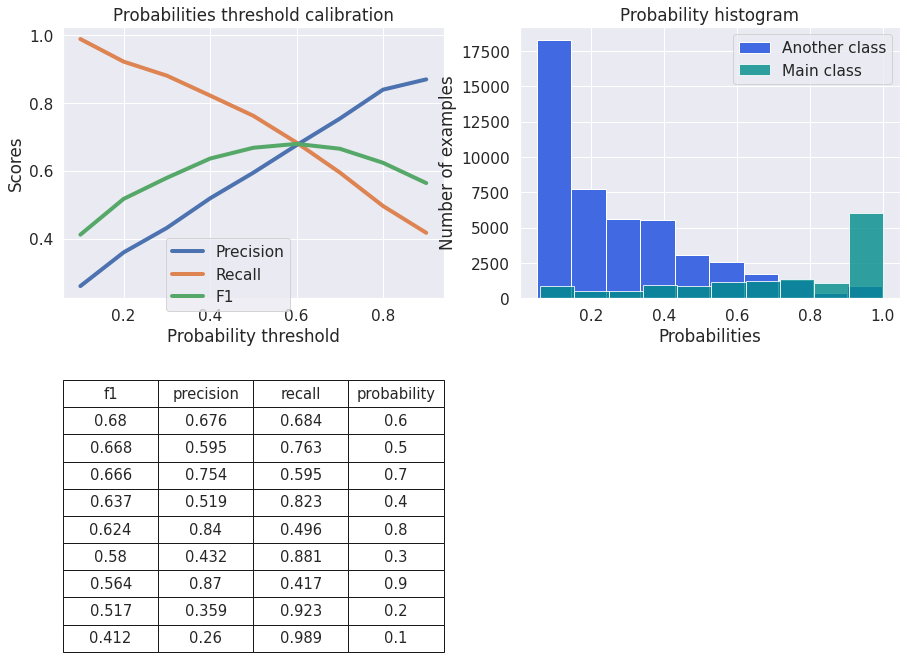

In [ ]:
show_proba_calibration_plots(base.predict_proba(X_test)[:, 1], y_test)

In [ ]:
# maximize f1_score by using threshold in probability
base_train_probs = base.predict_proba(X_train)
base_test_probs = base.predict_proba(X_test)
train_preds = np.apply_along_axis(lambda x: x[1] >= 0.6, axis=1, arr=base_train_probs)
test_preds = np.apply_along_axis(lambda x: x[1] >= 0.6, axis=1, arr=base_test_probs)
report(y_train, train_preds, y_test, test_preds)

Train
               precision    recall  f1-score   support

           0      0.903     0.896     0.900    121423
           1      0.675     0.692     0.683     37806

    accuracy                          0.848    159229
   macro avg      0.789     0.794     0.792    159229
weighted avg      0.849     0.848     0.848    159229

Test
               precision    recall  f1-score   support

           0      0.901     0.898     0.900     47220
           1      0.676     0.684     0.680     14703

    accuracy                          0.847     61923
   macro avg      0.789     0.791     0.790     61923
weighted avg      0.848     0.847     0.847     61923

Train ROC_AUC: 0.794, Test ROC_AUC: 0.791
Train GINI: 0.588, Test GINI: 0.582
Confusion Matrix 
 col_0    False  True 
Is_Lead              
0        42402   4818
1         4650  10053


In [ ]:
# RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5, max_features=X.shape[1], n_jobs=-1,
                            random_state=1, class_weight='balanced', min_samples_leaf=1)
rf.fit(X_train, y_train)
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

In [ ]:
report(y_train, rf_train_pred, y_test, rf_test_pred)
# overfitted

Train
               precision    recall  f1-score   support

           0      0.927     0.816     0.868    121423
           1      0.573     0.794     0.666     37806

    accuracy                          0.811    159229
   macro avg      0.750     0.805     0.767    159229
weighted avg      0.843     0.811     0.820    159229

Test
               precision    recall  f1-score   support

           0      0.926     0.818     0.868     47220
           1      0.574     0.789     0.665     14703

    accuracy                          0.811     61923
   macro avg      0.750     0.803     0.767     61923
weighted avg      0.842     0.811     0.820     61923

Train ROC_AUC: 0.805, Test ROC_AUC: 0.803
Train GINI: 0.610, Test GINI: 0.607
Confusion Matrix 
 col_0        0      1
Is_Lead              
0        38623   8597
1         3105  11598


In [ ]:
# XGBClassifier

In [ ]:
train_df[TARGET_NAME].value_counts(normalize=True)

0    0.762566
1    0.237434
Name: Is_Lead, dtype: float64

In [ ]:
xgboost = XGBClassifier(max_depth=4, learning_rate=0.01, n_estimators=350, n_jobs=-1, reg_lambda=1e-4, 
                     scale_pos_weight=3.21, gamma=0., random_state=1, seed=1, subsample=0.05, 
                     colsample_bytree=.8, silent=1, tree_method='hist')
xgboost.fit(X_train, y_train)
x_train_pred = xgboost.predict(X_train)
x_test_pred = xgboost.predict(X_test)

In [ ]:
report(y_train, x_train_pred, y_test, x_test_pred)

Train
               precision    recall  f1-score   support

           0      0.925     0.832     0.876    121423
           1      0.592     0.782     0.674     37806

    accuracy                          0.820    159229
   macro avg      0.758     0.807     0.775    159229
weighted avg      0.846     0.820     0.828    159229

Test
               precision    recall  f1-score   support

           0      0.923     0.833     0.876     47220
           1      0.592     0.776     0.672     14703

    accuracy                          0.820     61923
   macro avg      0.757     0.805     0.774     61923
weighted avg      0.844     0.820     0.827     61923

Train ROC_AUC: 0.807, Test ROC_AUC: 0.805
Train GINI: 0.615, Test GINI: 0.610
Confusion Matrix 
 col_0        0      1
Is_Lead              
0        39342   7878
1         3288  11415


Меры правильности перекрекстной оценки: [0.67538077 0.67466301 0.67343679 0.67046361 0.67083002 0.67402299
 0.67681818 0.68016101 0.67374429 0.67089923]
Точность перекретсной оценки: 0.674 +/- 0.003




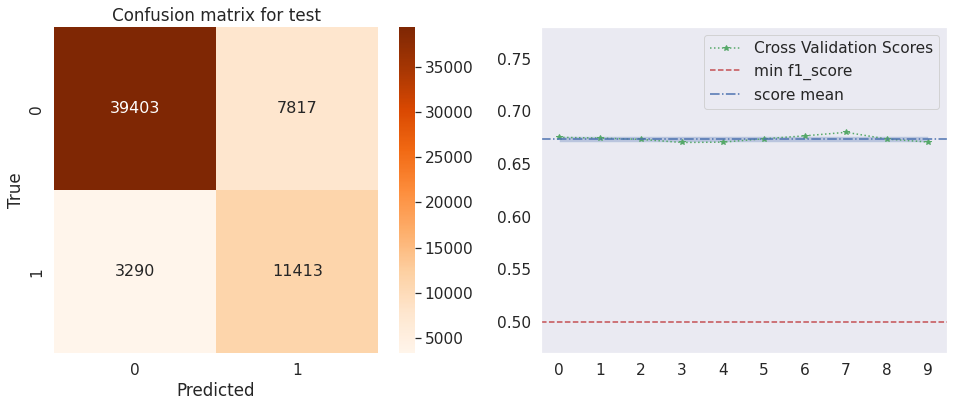

In [ ]:
plot_cm_val(y_test, x_test_pred, X_train, y_train, xgboost)

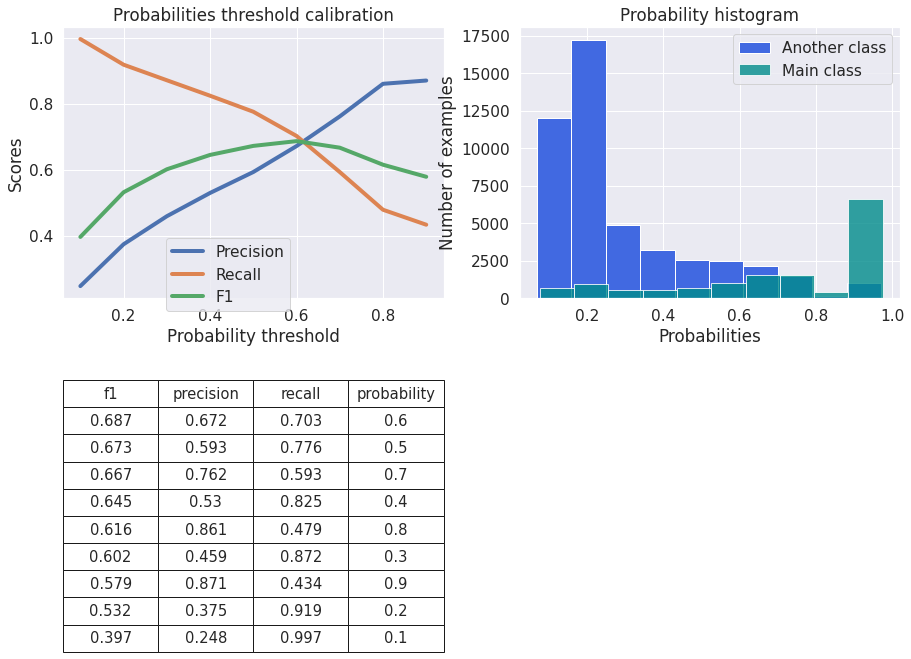

In [ ]:
show_proba_calibration_plots(xgboost.predict_proba(X_test)[:, 1], y_test)

In [ ]:
test_df = test_df[X_train.columns.to_list()]
base_final = base.predict(test_df)
x_final = xgboost.predict(test_df)

In [ ]:
!pip install shap
import shap

In [ ]:
# explains the predicted value
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(X_train)

In [ ]:
# plot for one observation (sample)
# in this paticular feature 'No Credit Product' impacts on the output in decreasing manner
#  and the 'AVT' increases the output
# lower -> is_lead = 0, higher -> is_lead = 1
# so a person who has pretty big account balance (AVT, AOT) and vintaged for a long time is more likely to lead, 
# but if he has no credit product yet he woudld more likely to reject (is_lead=0)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10000], features=X_train.iloc[10000], feature_names=X.columns)

In [ ]:
# the opposite situation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[11000], features=X_train.iloc[11000], feature_names=X.columns)

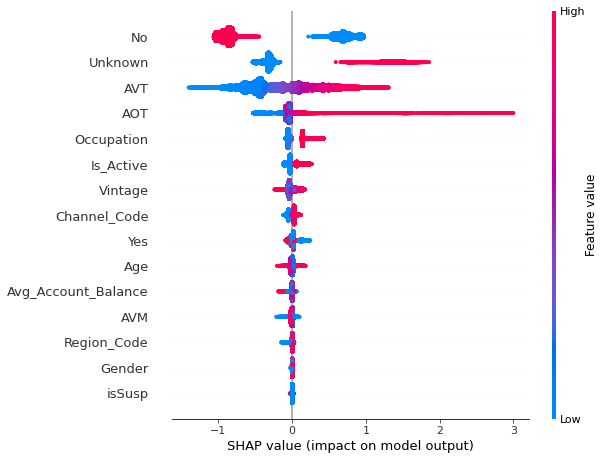

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, features=X_train, feature_names=X.columns)

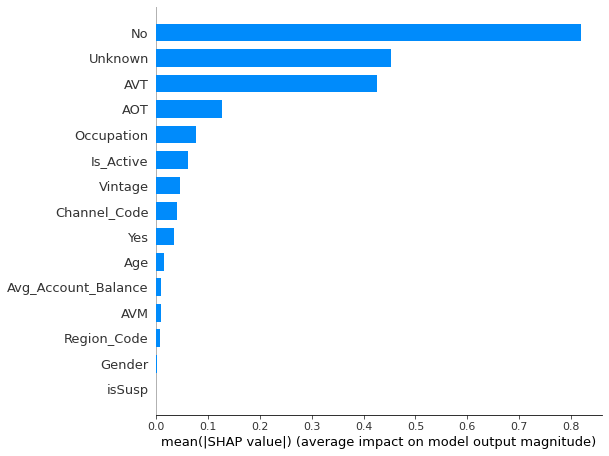

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, features=X_train, feature_names=X.columns, plot_type='bar')

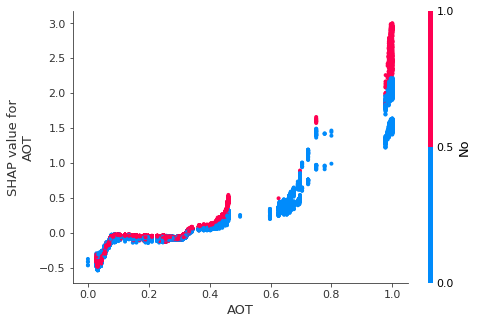

In [ ]:
shap.initjs()
shap.dependence_plot('AOT', shap_values, X_train, X.columns)

In [ ]:
# LGBMClassifier

In [ ]:
# try to set class_weight for minority class higher than is acually is. To strike model more on False Negatives
# maybe recall will improve
# other way is to calibrate probabilities using prob_calibration_plot

In [ ]:
lgbm = LGBMClassifier(boosting_type='goss', num_leaves=31, max_depth=5, learning_rate=0.01, n_estimators=250, 
                      subsample=0.5, colsample_bytree=.9, reg_lambda=1e-3, n_jobs=-1, silent=True, 
                      scale_pos_weight=3.21, random_state=1)
lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=10, 
         eval_metric='f1_score')
l_train_pred = lgbm.predict(X_train)
l_test_pred = lgbm.predict(X_test)

In [ ]:
report(y_train, l_train_pred, y_test, l_test_pred)

Train
               precision    recall  f1-score   support

           0      0.916     0.865     0.890    121423
           1      0.633     0.747     0.685     37806

    accuracy                          0.837    159229
   macro avg      0.775     0.806     0.787    159229
weighted avg      0.849     0.837     0.841    159229

Test
               precision    recall  f1-score   support

           0      0.914     0.866     0.889     47220
           1      0.632     0.740     0.682     14703

    accuracy                          0.836     61923
   macro avg      0.773     0.803     0.786     61923
weighted avg      0.847     0.836     0.840     61923

Train ROC_AUC: 0.806, Test ROC_AUC: 0.803
Train GINI: 0.612, Test GINI: 0.606
Confusion Matrix 
 col_0        0      1
Is_Lead              
0        40888   6332
1         3828  10875


Меры правильности перекрекстной оценки: [0.68047475 0.68170193 0.67638214 0.6742671  0.67523446 0.6784213
 0.67930198 0.68411827 0.68005106 0.67305669]
Точность перекретсной оценки: 0.678 +/- 0.003




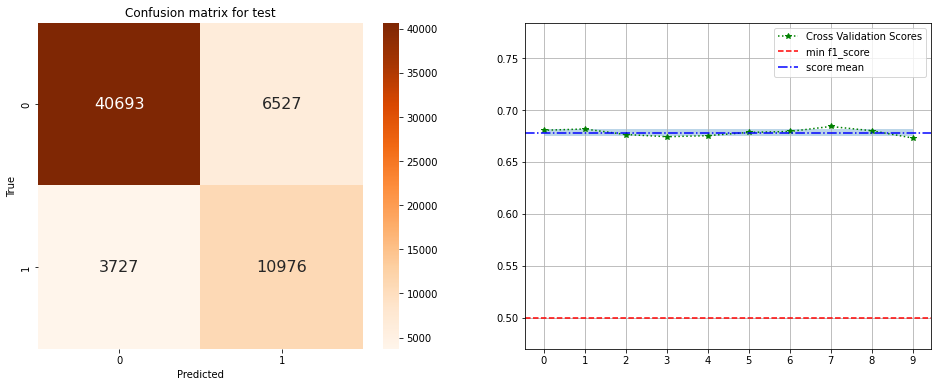

In [ ]:
plot_cm_val(y_test, l_test_pred, X_train, y_train, lgbm)

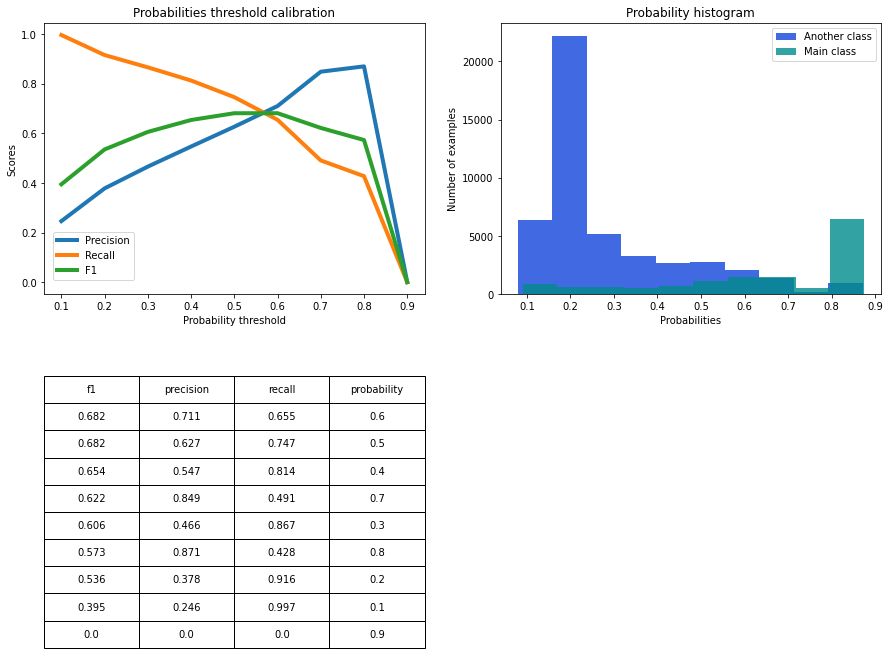

In [ ]:
show_proba_calibration_plots(lgbm.predict_proba(X_test)[:, 1], y_test)

In [ ]:
l_not_cat_final = lgbm.predict(test_df)

In [ ]:
# LGBMClassifier with cats / try sampling

In [ ]:
train_df = pd.read_csv(train_path)
train_df, test_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=1)
test_df, test_targets = test_df.drop(TARGET_NAME, axis=1), test_df[TARGET_NAME]
preprocessor = Preprocessor(with_cat=True)
train_df = preprocessor(train_df)
test_df = preprocessor(test_df)

Memory usage of dataframe is 25.31 MB
Memory usage after optimization is: 9.07 MB
Decreased by 64.2%
Memory usage of dataframe is 2.62 MB
Memory usage after optimization is: 0.98 MB
Decreased by 62.5%


In [ ]:
X, y = train_df.drop(TARGET_NAME, axis=1), train_df[TARGET_NAME]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, shuffle=True, stratify=y, random_state=1)

In [ ]:
cat_cols = X_train.select_dtypes(['category', 'int8']).columns.to_list()
cat_cols_idxs = [i for i in range(X.shape[1]) if X.columns[i] in cat_cols]

In [ ]:
smote = SMOTENC(categorical_features=cat_cols_idxs, sampling_strategy=0.35, random_state=1, n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=X_test.columns)
y_train = pd.DataFrame(y_train, columns=[TARGET_NAME])

In [ ]:
for j in [X_train, X_test]:
    for i in range(X.shape[1]):
        if i not in cat_cols_idxs:
            j.iloc[:, i] = j.iloc[:, i].astype(np.float32)
        else:
            j.iloc[:, i] = j.iloc[:, i].astype('category')

In [ ]:
lgbm_cat = LGBMClassifier(boosting_type='goss', num_leaves=31, max_depth=4, learning_rate=0.005, n_estimators=350,
                          scale_pos_weight=2.5, subsample=0.9, colsample_bytree=0.5, reg_lambda=1e-5, # 3.21
                          random_state=1)
lgbm_cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=10, 
         eval_metric='f1_score', categorical_feature=cat_cols_idxs)
lcat_train_pred = lgbm_cat.predict(X_train)
lcat_test_pred = lgbm_cat.predict(X_test)

In [ ]:
report(y_train, lcat_train_pred, y_test, lcat_test_pred)

Train
               precision    recall  f1-score   support

           0      0.905     0.871     0.888    121423
           1      0.667     0.738     0.701     42498

    accuracy                          0.837    163921
   macro avg      0.786     0.804     0.794    163921
weighted avg      0.843     0.837     0.839    163921

Test
               precision    recall  f1-score   support

           0      0.911     0.872     0.891     47220
           1      0.639     0.725     0.679     14703

    accuracy                          0.837     61923
   macro avg      0.775     0.799     0.785     61923
weighted avg      0.846     0.837     0.841     61923

Train ROC_AUC: 0.804, Test ROC_AUC: 0.799
Train GINI: 0.609, Test GINI: 0.597
Confusion Matrix 
 col_0        0      1
Is_Lead              
0        41197   6023
1         4044  10659


In [ ]:
# CatBoostClassifier + randomized search / try sampling SMOTENC

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols) 
params_model = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    #'scale_pos_weight': 3.21,
    'silent': True,
    'one_hot_max_size': 5,
    'early_stopping_rounds': 10,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,
    'random_seed': 1
}
# we can push up scale_pos_weight to strike the model more to improve FN
# we can define custom eval_metric class to minimize specific error loss_fn

In [ ]:
catboost = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=50, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8002369961
bestIteration = 55

0:	loss: 0.8002370	best: 0.8002370 (0)	total: 8.77s	remaining: 7m 9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.796503321
bestIteration = 14

1:	loss: 0.7965033	best: 0.8002370 (0)	total: 12s	remaining: 4m 47s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7986123178
bestIteration = 13

2:	loss: 0.7986123	best: 0.8002370 (0)	total: 15.5s	remaining: 4m 3s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7988570239
bestIteration = 31

3:	loss: 0.7988570	best: 0.8002370 (0)	total: 21.9s	remaining: 4m 12s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.800996336
bestIteration = 4

4:	loss: 0.8009963	best: 0.8009963 (4)	total: 23.9s	remaining: 3m 35s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7989430449
bestIteration = 18

5:	loss: 0.7989430	best: 0.8009963 (4)	total: 28.1s	remaining: 

In [ ]:
gs['params']

{'bagging_temperature': 1.5,
 'depth': 7,
 'iterations': 400,
 'l2_leaf_reg': 4,
 'learning_rate': 0.1,
 'subsample': 0.3}

In [ ]:
catboost = CatBoostClassifier(**params_model, depth=7, iterations=400, learning_rate=0.1, l2_leaf_reg=4.,
                              bagging_temperature=1.5, subsample=0.5)
catboost.fit(train_pool, eval_set=test_pool)
cat_train_pred = catboost.predict(X_train)
cat_test_pred = catboost.predict(X_test)

In [ ]:
report(y_train, cat_train_pred, y_test, cat_test_pred)

Train
               precision    recall  f1-score   support

           0      0.925     0.831     0.875    121423
           1      0.590     0.784     0.674     37806

    accuracy                          0.820    159229
   macro avg      0.758     0.807     0.775    159229
weighted avg      0.846     0.820     0.827    159229

Test
               precision    recall  f1-score   support

           0      0.923     0.832     0.875     47220
           1      0.590     0.778     0.671     14703

    accuracy                          0.819     61923
   macro avg      0.757     0.805     0.773     61923
weighted avg      0.844     0.819     0.827     61923

Train ROC_AUC: 0.807, Test ROC_AUC: 0.805
Train GINI: 0.615, Test GINI: 0.610
Confusion Matrix 
 col_0        0      1
Is_Lead              
0        39288   7932
1         3269  11434


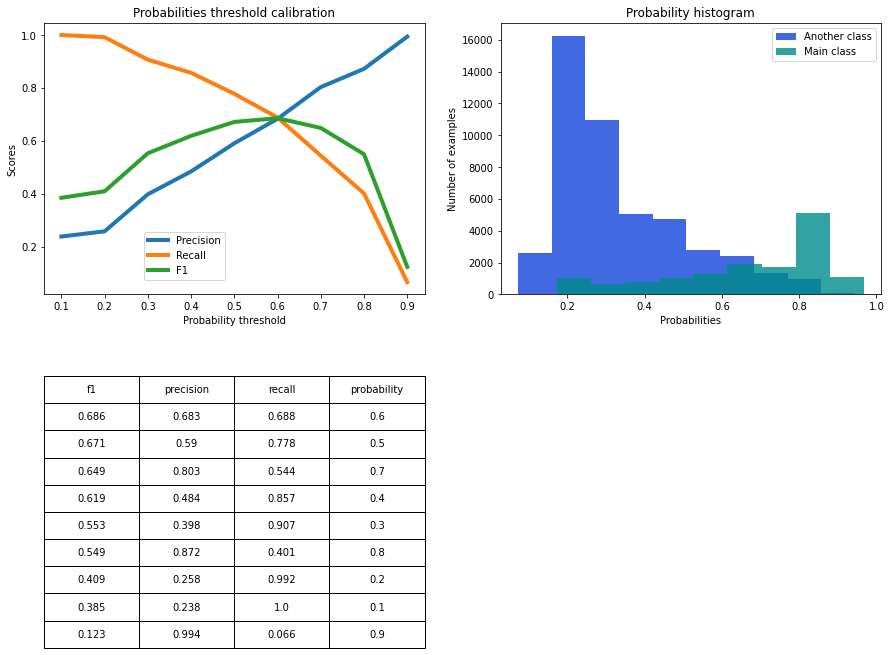

In [ ]:
show_proba_calibration_plots(catboost.predict_proba(X_test)[:, 1], y_test)

In [ ]:
# maximize f1_score by using threshold in probability
base_train_probs = catboost.predict_proba(X_train)
base_test_probs = catboost.predict_proba(X_test)
train_preds = np.apply_along_axis(lambda x: x[1] >= 0.6, axis=1, arr=base_train_probs)
test_preds = np.apply_along_axis(lambda x: x[1] >= 0.6, axis=1, arr=base_test_probs)
report(y_train, train_preds, y_test, test_preds)

Train
               precision    recall  f1-score   support

           0      0.905     0.900     0.902    121423
           1      0.684     0.697     0.690     37806

    accuracy                          0.851    159229
   macro avg      0.794     0.798     0.796    159229
weighted avg      0.852     0.851     0.852    159229

Test
               precision    recall  f1-score   support

           0      0.903     0.901     0.902     47220
           1      0.683     0.688     0.686     14703

    accuracy                          0.850     61923
   macro avg      0.793     0.794     0.794     61923
weighted avg      0.851     0.850     0.850     61923

Train ROC_AUC: 0.798, Test ROC_AUC: 0.794
Train GINI: 0.596, Test GINI: 0.589
Confusion Matrix 
 col_0    False  True 
Is_Lead              
0        42528   4692
1         4588  10115


In [ ]:
cat_final = catboost.predict(test_df)
cat_final_proba = catboost.predict_proba(test_df)
cat_final_proba = np.apply_along_axis(lambda x: x[1] >= 0.6, axis=1, arr=cat_final_proba)

In [ ]:
# custom ensemble

In [ ]:
submission_vote = vote([base_final, x_final, l_not_cat_final, cat_final], weights=[1.8, 1.8, 2.2, 1.2])
submission_vote_ = vote([base_final, x_final, l_not_cat_final, cat_final_proba], weights=[1.5, 1.5, 2.2, 2.5])

In [ ]:
print(classification_report(submission_vote, test_targets, digits=3))
print('Confusion Matrix', '\n', pd.crosstab(test_targets, submission_vote))
print(f'ROC_AUC: {roc_auc_score(test_targets, submission_vote):.3f}, GINI: {(2*roc_auc_score(test_targets, submission_vote)-1):.3f}')

              precision    recall  f1-score   support

           0      0.835     0.917     0.874     17129
           1      0.753     0.585     0.658      7444

    accuracy                          0.816     24573
   macro avg      0.794     0.751     0.766     24573
weighted avg      0.811     0.816     0.809     24573

Confusion Matrix 
 col_0        0     1
Is_Lead             
0        15702  3092
1         1427  4352
ROC_AUC: 0.794, GINI: 0.589


In [ ]:
print(classification_report(submission_vote_, test_targets, digits=3))
print('Confusion Matrix', '\n', pd.crosstab(test_targets, submission_vote_))
print(f'ROC_AUC: {roc_auc_score(test_targets, submission_vote_):.3f}, GINI: {(2*roc_auc_score(test_targets, submission_vote_)-1):.3f}')

              precision    recall  f1-score   support

           0      0.860     0.910     0.884     17753
           1      0.723     0.613     0.664      6820

    accuracy                          0.828     24573
   macro avg      0.792     0.762     0.774     24573
weighted avg      0.822     0.828     0.823     24573

Confusion Matrix 
 col_0        0     1
Is_Lead             
0        16155  2639
1         1598  4181
ROC_AUC: 0.792, GINI: 0.583


In [ ]:
cat_final_recall_proba = catboost.predict_proba(test_df)
cat_final_recall_proba = np.apply_along_axis(lambda x: x[1] >= 0.1, axis=1, arr=cat_final_recall_proba)

In [ ]:
for x in [base_final, x_final, l_not_cat_final, cat_final, cat_final_proba, cat_final_recall_proba]:
    print('\nConfusion Matrix\n', '='*40, '\n', pd.crosstab(test_targets, x))
    print(f'ROC_AUC: {roc_auc_score(test_targets, x):.3f}, GINI: {(2*roc_auc_score(test_targets, x)-1):.3f}')


Confusion Matrix
 col_0        0     1
Is_Lead             
0        15609  3185
1         1442  4337
ROC_AUC: 0.791, GINI: 0.581

Confusion Matrix
 col_0        0     1
Is_Lead             
0        15545  3249
1         1373  4406
ROC_AUC: 0.795, GINI: 0.590

Confusion Matrix
 col_0        0     1
Is_Lead             
0        16041  2753
1         1537  4242
ROC_AUC: 0.794, GINI: 0.588

Confusion Matrix
 col_0        0     1
Is_Lead             
0        15544  3250
1         1343  4436
ROC_AUC: 0.797, GINI: 0.595

Confusion Matrix
 col_0    False  True 
Is_Lead              
0        16797   1997
1         1874   3905
ROC_AUC: 0.785, GINI: 0.569

Confusion Matrix
 col_0    False  True 
Is_Lead              
0           69  18725
1            3   5776
ROC_AUC: 0.502, GINI: 0.003


In [ ]:
train_df = pd.read_csv(train_path)
train_df, test_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=1)
test_df, test_targets = test_df.drop(TARGET_NAME, axis=1), test_df[TARGET_NAME]
train_df.Credit_Product.fillna('unk', inplace=True)
test_df.Credit_Product.fillna('unk', inplace=True)
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)
train_df = preprocessor.reduce_memory(train_df)
test_df = preprocessor.reduce_memory(test_df)

Memory usage of dataframe is 18.56 MB
Memory usage after optimization is: 4.64 MB
Decreased by 75.0%
Memory usage of dataframe is 1.87 MB
Memory usage after optimization is: 0.49 MB
Decreased by 73.6%


In [ ]:
X, y = train_df.drop(TARGET_NAME, axis=1), train_df[TARGET_NAME]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, shuffle=True, stratify=y, random_state=1)

In [ ]:
cat_cols = X_train.select_dtypes(['category']).columns.to_list()

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols) 
params_model = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 5,
    'early_stopping_rounds': 10,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,
    'random_seed': 1
}

In [ ]:
catboost = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=50, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7938862512
bestIteration = 17

0:	loss: 0.7938863	best: 0.7938863 (0)	total: 3.98s	remaining: 3m 15s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7934231118
bestIteration = 18

1:	loss: 0.7934231	best: 0.7938863 (0)	total: 7.93s	remaining: 3m 10s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7944841371
bestIteration = 28

2:	loss: 0.7944841	best: 0.7944841 (2)	total: 13.3s	remaining: 3m 28s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7944012676
bestIteration = 31

3:	loss: 0.7944013	best: 0.7944841 (2)	total: 20.1s	remaining: 3m 50s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7948809752
bestIteration = 9

4:	loss: 0.7948810	best: 0.7948810 (4)	total: 22.7s	remaining: 3m 24s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7929681976
bestIteration = 2

5:	loss: 0.7929682	best: 0.7948810 (4)	total: 24.7s	remain

In [ ]:
gs['params']

{'bagging_temperature': 2,
 'depth': 4,
 'iterations': 400,
 'l2_leaf_reg': 2.5,
 'learning_rate': 0.5,
 'subsample': 0.5}

In [ ]:
catboost_raw = CatBoostClassifier(**params_model, depth=5, iterations=400, learning_rate=0.5, l2_leaf_reg=2.5,
                              bagging_temperature=2, subsample=0.9)
catboost_raw.fit(train_pool, eval_set=test_pool)
cat_raw_train_pred = catboost_raw.predict(X_train)
cat_raw_test_pred = catboost_raw.predict(X_test)

In [ ]:
report(y_train, cat_raw_train_pred, y_test, cat_raw_test_pred)

Train
               precision    recall  f1-score   support

           0      0.923     0.837     0.878    121423
           1      0.598     0.776     0.675     37806

    accuracy                          0.823    159229
   macro avg      0.760     0.807     0.777    159229
weighted avg      0.846     0.823     0.830    159229

Test
               precision    recall  f1-score   support

           0      0.921     0.841     0.879     47220
           1      0.600     0.769     0.674     14703

    accuracy                          0.824     61923
   macro avg      0.761     0.805     0.777     61923
weighted avg      0.845     0.824     0.830     61923

Train ROC_AUC: 0.807, Test ROC_AUC: 0.805
Train GINI: 0.613, Test GINI: 0.609
Confusion Matrix 
 col_0        0      1
Is_Lead              
0        39695   7525
1         3402  11301


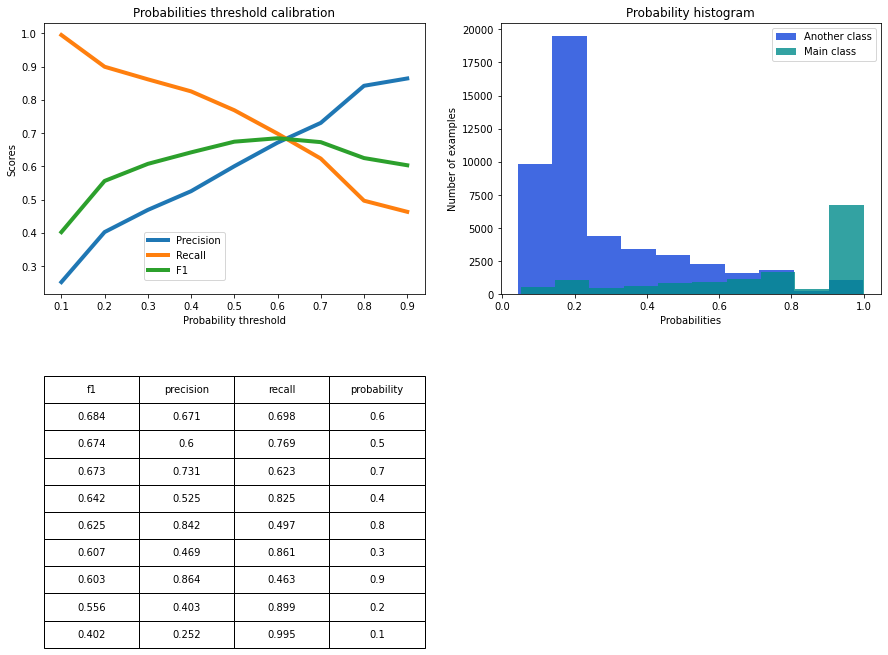

In [ ]:
show_proba_calibration_plots(catboost_raw.predict_proba(X_test)[:, 1], y_test)

In [ ]:
raw_pred = catboost_raw.predict(test_df)

In [ ]:
print(classification_report(raw_pred, test_targets, digits=3))
print('Confusion Matrix', '\n', pd.crosstab(test_targets, raw_pred))
print(f'ROC_AUC: {roc_auc_score(test_targets, raw_pred):.3f}, GINI: {(2*roc_auc_score(test_targets, raw_pred)-1):.3f}')

              precision    recall  f1-score   support

           0      0.837     0.921     0.877     17069
           1      0.767     0.591     0.668      7504

    accuracy                          0.820     24573
   macro avg      0.802     0.756     0.772     24573
weighted avg      0.815     0.820     0.813     24573

Confusion Matrix 
 col_0        0     1
Is_Lead             
0        15724  3070
1         1345  4434
ROC_AUC: 0.802, GINI: 0.604
